In [1]:
import torch
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'
batch_size = 64

train_set = MNIST(download_root, transform=transform, train=True, download=True)
test_set = MNIST(download_root, transform=transform, train=False, download=True)

train_dataset = torch.utils.data.DataLoader(MNIST(download_root, transform=transform, train=True, download=True), batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = torch.utils.data.DataLoader(MNIST(download_root, transform=transform, train=False, download=True), batch_size=len(test_set), shuffle=True, drop_last=True)

/usr/local/var/pyenv/versions/3.7.10/envs/NLP/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

epoch마다 writer.add_scalar(이름 , y값 ,x값)

In [2]:
# 하나의 이미지 예시
images, labels = next(iter(train_dataset))

In [3]:
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
torch_image = images[0]
print(torch_image.shape)
torch_image = torch.squeeze(torch_image)
print(torch_image.shape)

label = labels[0].numpy()
print(label)

torch.Size([1, 28, 28])
torch.Size([28, 28])
6


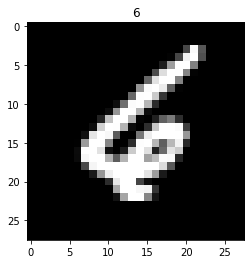

In [6]:
plt.title(label)
plt.imshow(torch_image, 'gray')
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.layer(x)

In [9]:
from sklearn.preprocessing import label_binarize

def drawROCandAUCscore(pred, target):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 10
    classes = [i for i in range(n_classes)]
    pred = label_binarize(pred, classes=classes)
    target = label_binarize(target, classes=classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(pred[:, i], target[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(20, 10))
    for idx, i in enumerate(range(n_classes)):
        plt.subplot(2,5,i+1)
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate', rotation=0)
        plt.title('Class %0.0f' % idx)
        plt.legend(loc="lower right")
    plt.show()

    print("roc_auc_score: ", roc_auc_score(pred, target, multi_class='ovo'))

In [10]:
model = Model().to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.cross_entropy
# 텐서보드로 그리기
writer = SummaryWriter()

In [12]:
def train(model, train_dataset, optimizer):
    model.train()
    loss_val = 0
    for data, target in train_dataset:
        data = data.view(-1, 28*28).to(device)
        target = target.to(device)
        pred = model(data)
        optimizer.zero_grad()
        loss = loss_fn(pred, target)
        loss_val = loss.item()
        loss.backward()
        optimizer.step()
    print("Train Epoch: {} ".format(epoch))

def evaluate(model, test_dataset):
    model.eval()
    test_loss = 0
    correct = 0
    cf_matrix = np.zeros((10, 10), dtype=np.int)
    labels = [i for i in range(10)]
    with torch.no_grad(): # 평가 과정에서는 기울기를 계산하지 않으므로, no_grad명시
        for data, target in test_dataset:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.argmax(1)
# 일반 반복문을 통해 confusion matrix 생성            
#             for i in range(batch_size):
#                 confusion_matrix[pred[i]][target[i]] += 1

            cf_matrix += confusion_matrix(pred.cpu().numpy(), target.cpu().numpy(), labels=labels)
            
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataset.dataset)
    test_accuracy = 100. * correct / len(test_dataset.dataset)
    
# 평가 지표들 계산(Confusion matrix, recall, precision, accuracy, loss, f1 score, roc, auc)
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    print("Confusion Matrix: ", cf_matrix)
    recall_all = recall_score(pred, target, average=None)
    recall_avg = recall_score(pred, target, average='weighted')
    print("recall all:", recall_all)
    print("recall avg:", recall_avg)
    precision_all = precision_score(pred, target, average=None)
    precision_avg = precision_score(pred, target, average='weighted')
    print("precision all:", precision_all)
    print("precision avg:", precision_avg)
    f1_avg = f1_score(pred, target, average='weighted')
    print("f1 avg:", f1_avg)
    writer.add_scalar('test_accuracy', test_accuracy, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_recall(avg)', recall_avg, epoch)
    writer.add_scalar('test_precision(avg)', precision_avg, epoch)
    writer.add_scalar('test_f1(avg)', f1_avg, epoch)
    drawROCandAUCscore(pred, target)
    return test_loss, test_accuracy

MNIST Training...:   0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1 
Confusion Matrix:  [[ 964    0    6    0    1    5    8    0    6    4]
 [   0 1117    1    0    0    0    3   16    2    8]
 [   1    2  983    4    1    0    0    9    2    1]
 [   2    3   13  991    1   24    1    8   18   14]
 [   0    0    9    0  947    2    5    1    4   14]
 [   2    1    0    1    0  830    6    0    3    1]
 [   6    4    5    1   11   10  930    0    6    0]
 [   2    0    9    6    0    1    0  974    6    5]
 [   1    8    6    3    2   13    5    3  925    5]
 [   2    0    0    4   19    7    0   17    2  957]]
recall all: [0.96981891 0.97384481 0.98005982 0.92186047 0.96435845 0.98341232
 0.95580678 0.97108674 0.95262616 0.94940476]
recall avg: 0.9618
precision all: [0.98367347 0.98414097 0.95251938 0.98118812 0.96435845 0.93049327
 0.97077244 0.94747082 0.94969199 0.94846383]
precision avg: 0.9622148885188493
f1 avg: 0.9617981362198454


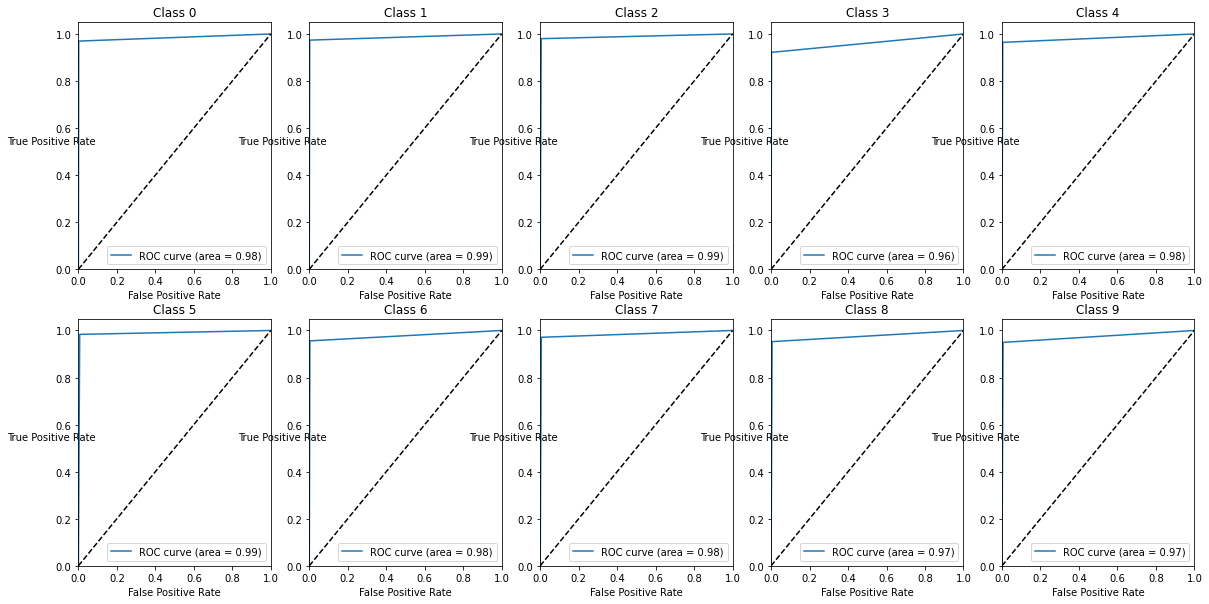

MNIST Training...:   7%|▋         | 1/15 [00:15<03:36, 15.48s/it]

roc_auc_score:  0.9789963995495649
[1] Test Loss: 0.1221, Accuracy: 96.18%
Train Epoch: 2 
Confusion Matrix:  [[ 966    0    5    0    2    2    6    1    1    3]
 [   0 1114    0    0    0    0    3   11    0    5]
 [   0    3 1005    7    0    0    0    9    1    1]
 [   1    1    1  971    0    7    0    1    2    5]
 [   0    0    4    0  961    3    3    3    5   15]
 [   2    0    0    6    0  865    5    0    2    1]
 [   5    3    6    0    8    5  935    0    2    1]
 [   0    1    4    6    1    0    0  993    4    4]
 [   4   13    7   14    1    7    6    2  954    8]
 [   2    0    0    6    9    3    0    8    3  966]]
recall all: [0.97971602 0.98323036 0.97953216 0.9817998  0.9668008  0.98183882
 0.96891192 0.98025666 0.93897638 0.96890672]
recall avg: 0.973
precision all: [0.98571429 0.9814978  0.97383721 0.96138614 0.97861507 0.96973094
 0.97599165 0.96595331 0.97946612 0.95738355]
precision avg: 0.9730987114808755
f1 avg: 0.9729766199670005


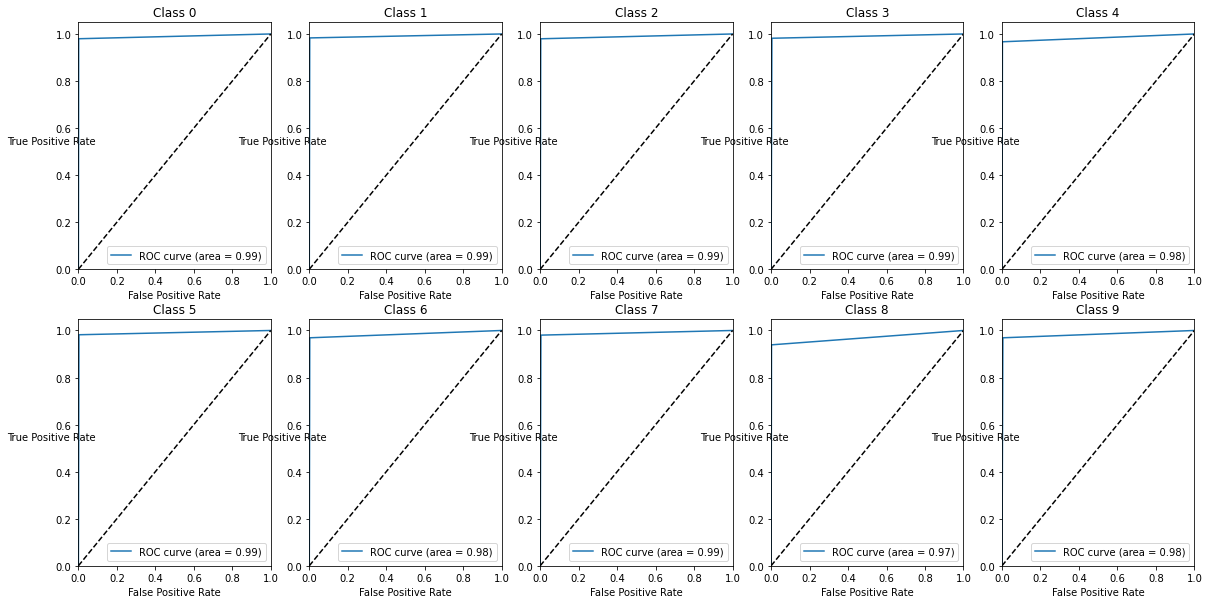

MNIST Training...:  13%|█▎        | 2/15 [00:30<03:21, 15.48s/it]

roc_auc_score:  0.9849988139177966
[2] Test Loss: 0.0881, Accuracy: 97.30%
Train Epoch: 3 
Confusion Matrix:  [[ 968    0    1    0    1    2    4    1    2    2]
 [   0 1123    1    0    0    0    3    7    0    2]
 [   2    4 1009    1    0    0    1    9    3    1]
 [   3    1    8  999    0   42    1    4   11   11]
 [   0    0    3    0  968    2    2    4    4   13]
 [   0    0    0    0    0  834    6    0    0    1]
 [   4    2    3    0    6    4  938    0    2    1]
 [   1    0    2    5    0    1    0  993    3    5]
 [   2    5    5    3    1    5    3    3  946    4]
 [   0    0    0    2    6    2    0    7    3  969]]
recall all: [0.98674822 0.98855634 0.97961165 0.925      0.97188755 0.99167658
 0.97708333 0.98316832 0.96827021 0.97977755]
recall avg: 0.9747
precision all: [0.9877551  0.98942731 0.97771318 0.98910891 0.98574338 0.93497758
 0.97912317 0.96595331 0.97125257 0.96035679]
precision avg: 0.9750653639386024
f1 avg: 0.9746739267148455


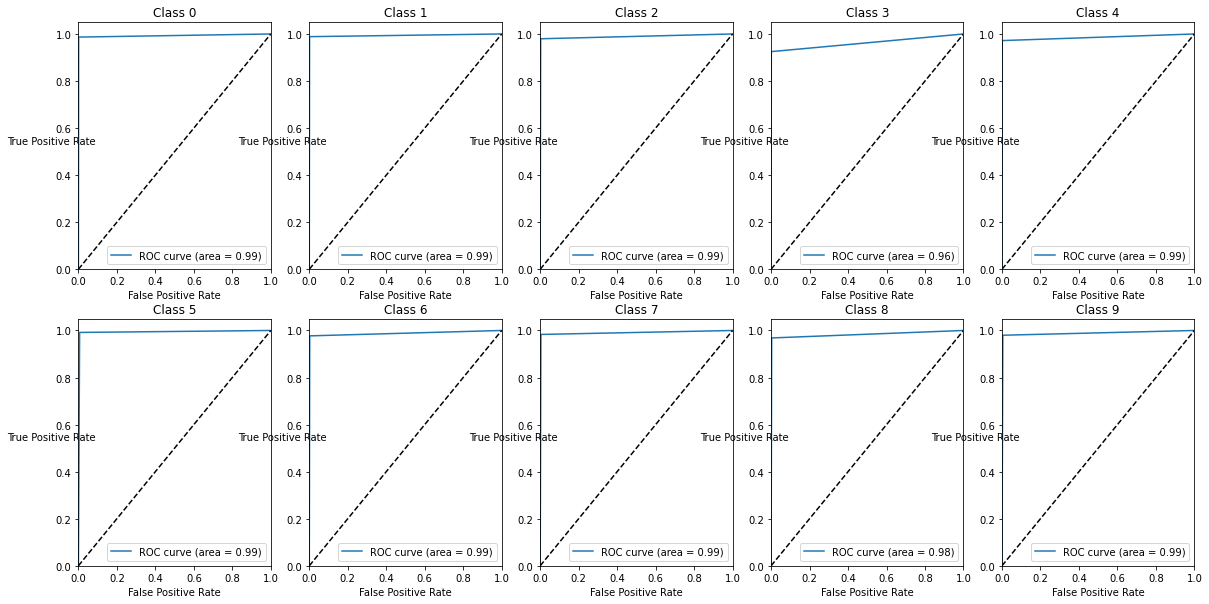

MNIST Training...:  20%|██        | 3/15 [00:46<03:05, 15.44s/it]

roc_auc_score:  0.9861881454836345
[3] Test Loss: 0.0797, Accuracy: 97.47%
Train Epoch: 4 
Confusion Matrix:  [[ 970    0    3    0    1    1    4    1    0    1]
 [   0 1112    4    0    0    0    3    7    0    3]
 [   0    2 1001    0    1    0    1   12    3    0]
 [   3    1   13 1005    1   18    1   17    5   11]
 [   0    0    2    0  949    1    3    1    1    7]
 [   0    0    0    1    0  862    5    0    5    5]
 [   2    1    3    0    6    4  937    0    2    0]
 [   0    0    2    2    2    0    0  979    2    1]
 [   4   19    4    2    1    6    4    4  954    7]
 [   1    0    0    0   21    0    0    7    2  974]]
recall all: [0.98878695 0.98494243 0.98137255 0.93488372 0.98443983 0.98177677
 0.98115183 0.99089069 0.94925373 0.96915423]
recall avg: 0.9743
precision all: [0.98979592 0.97973568 0.96996124 0.9950495  0.96639511 0.96636771
 0.97807933 0.95233463 0.97946612 0.96531219]
precision avg: 0.9745700382482166
f1 avg: 0.9742544127285792


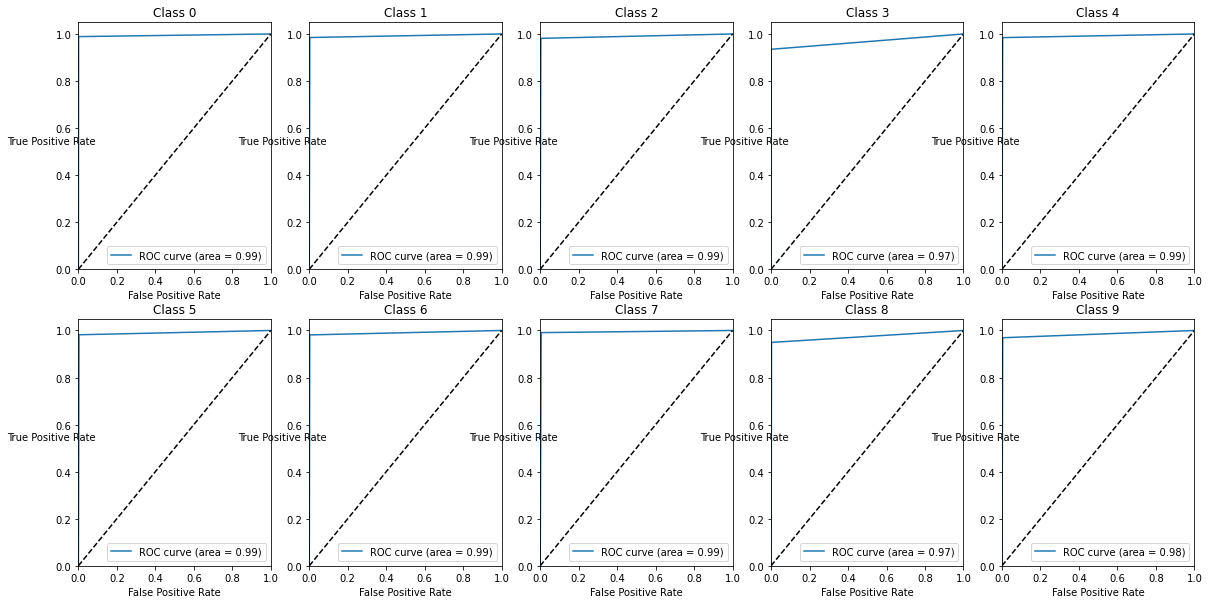

MNIST Training...:  27%|██▋       | 4/15 [01:01<02:50, 15.51s/it]

roc_auc_score:  0.9859062331322065
[4] Test Loss: 0.0796, Accuracy: 97.43%
Train Epoch: 5 
Confusion Matrix:  [[ 962    0    1    0    1    0    3    0    0    0]
 [   0 1121    0    0    0    0    3    2    0    3]
 [   2    3 1013    2    2    0    3    7    5    0]
 [   4    3   11  994    2   10    1    3   14    6]
 [   1    0    1    0  944    0    7    0    3    3]
 [   3    0    0    5    0  876   14    0    6    5]
 [   0    1    0    0    7    0  925    0    1    0]
 [   1    3    5    2    4    1    0 1009    3    4]
 [   3    4    1    0    1    3    2    1  938    2]
 [   4    0    0    7   21    2    0    6    4  986]]
recall all: [0.99482937 0.99291408 0.97685632 0.94847328 0.98435871 0.96369637
 0.99036403 0.97771318 0.98219895 0.95728155]
recall avg: 0.9768
precision all: [0.98163265 0.9876652  0.98158915 0.98415842 0.96130346 0.98206278
 0.96555324 0.98151751 0.96303901 0.97720515]
precision avg: 0.9769180196820345
f1 avg: 0.976763207583393


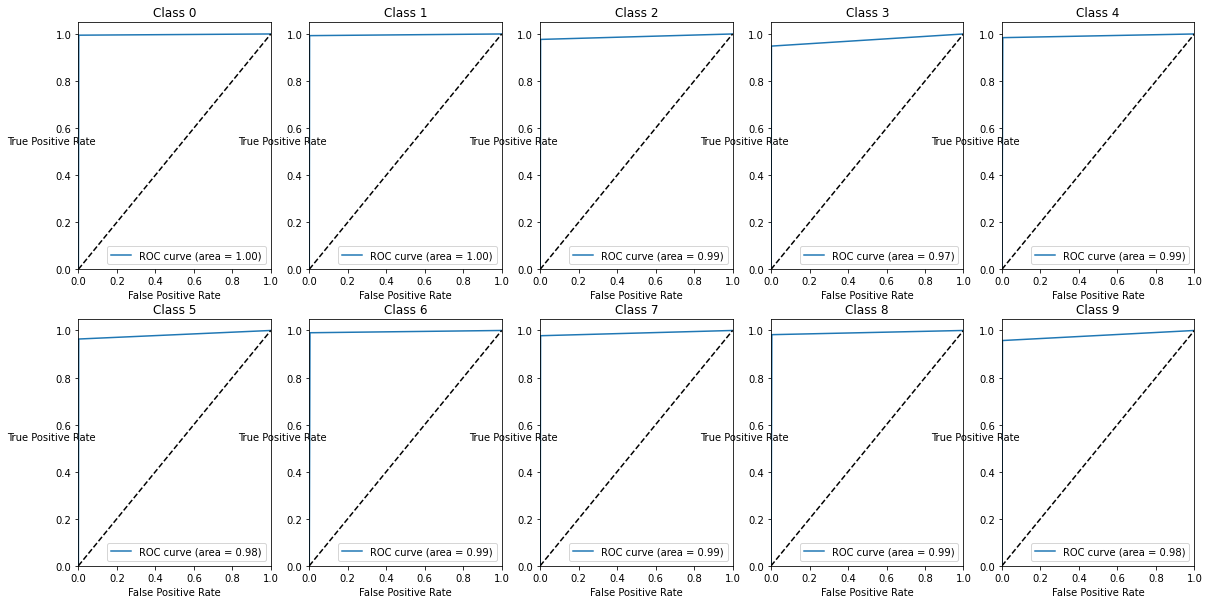

MNIST Training...:  33%|███▎      | 5/15 [01:17<02:35, 15.51s/it]

roc_auc_score:  0.9871470977772315
[5] Test Loss: 0.0784, Accuracy: 97.68%
Train Epoch: 6 
Confusion Matrix:  [[ 975    0    6    0    1    3    4    2    8    6]
 [   0 1126    1    0    0    0    2    4    1    3]
 [   1    3 1015   11    2    0    2    9    3    0]
 [   0    0    1  969    0    1    0    0    1    2]
 [   0    0    1    0  965    1    6    4    5    9]
 [   0    0    0   10    0  883    5    0    8    4]
 [   1    2    0    0    6    2  938    0    1    0]
 [   0    0    5    5    1    0    0  999    3    0]
 [   2    4    3    3    0    1    1    1  938    3]
 [   1    0    0   12    7    1    0    9    6  982]]
recall all: [0.97014925 0.99032542 0.97036329 0.99486653 0.97376387 0.97032967
 0.98736842 0.98617966 0.98117155 0.96463654]
recall avg: 0.979
precision all: [0.99489796 0.99207048 0.98352713 0.95940594 0.98268839 0.98991031
 0.97912317 0.97178988 0.96303901 0.97324083]
precision avg: 0.9791764568700493
f1 avg: 0.9790085613052252


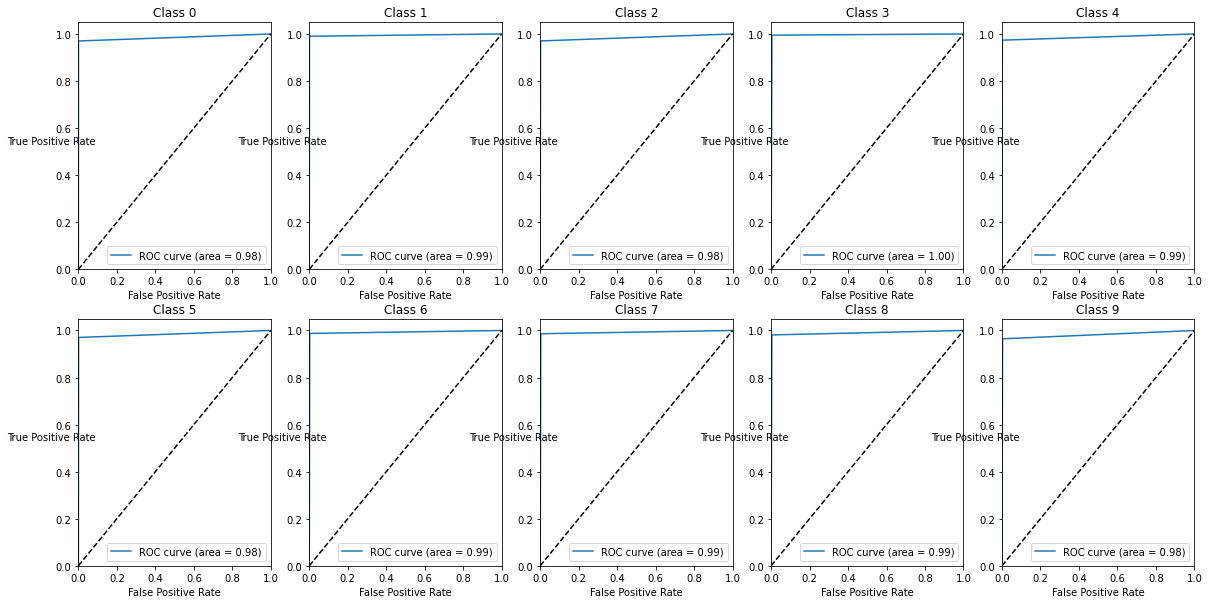

MNIST Training...:  40%|████      | 6/15 [01:33<02:20, 15.60s/it]

roc_auc_score:  0.9882920691383041
[6] Test Loss: 0.0737, Accuracy: 97.90%
Train Epoch: 7 
Confusion Matrix:  [[ 970    0    4    0    0    1    5    1    1    0]
 [   0 1112    3    1    0    0    2    7    0    2]
 [   0    1  990    1    1    0    1    5    2    0]
 [   1    2   14  962    0    2    0    8    2    1]
 [   0    0    1    0  939    1    5    1    3    4]
 [   0    3    1   31    1  882   36    0    8    7]
 [   1    2    0    0    7    0  905    0    1    0]
 [   1    0    2    2    0    0    1  985    1    2]
 [   5   14   17    4    0    4    3    5  951    2]
 [   2    1    0    9   34    2    0   16    5  991]]
recall all: [0.98778004 0.98669033 0.98901099 0.96975806 0.98427673 0.91021672
 0.98799127 0.99094567 0.94626866 0.93490566]
recall avg: 0.9687
precision all: [0.98979592 0.97973568 0.95930233 0.95247525 0.95621181 0.98878924
 0.94467641 0.95817121 0.97638604 0.98216056]
precision avg: 0.9691725545626161
f1 avg: 0.9685702454682124


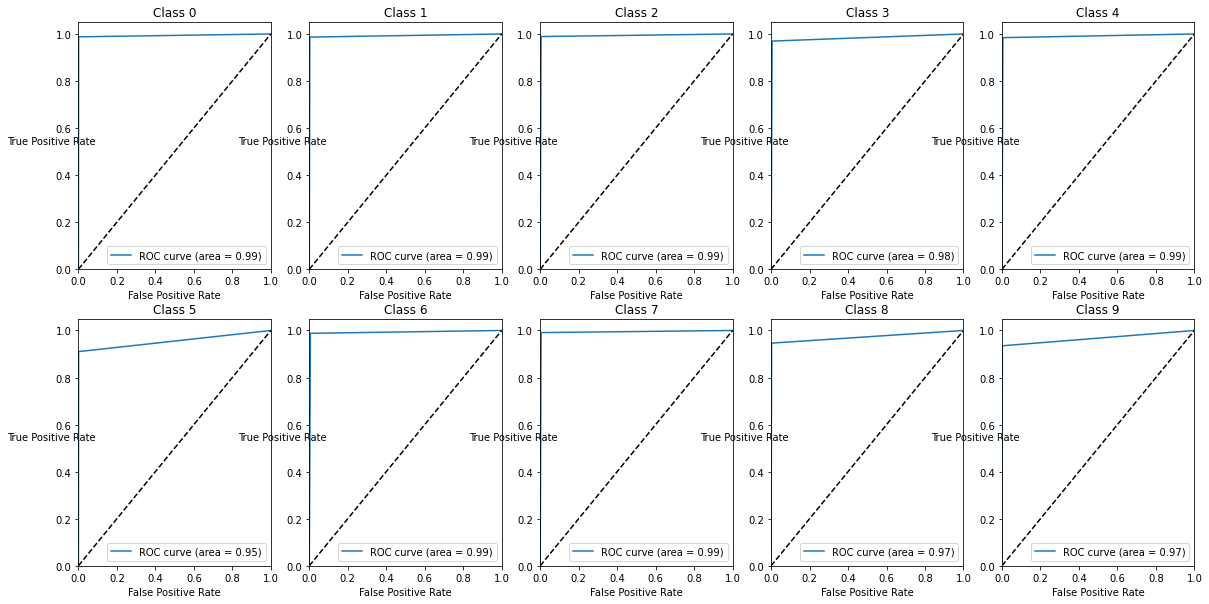

MNIST Training...:  47%|████▋     | 7/15 [01:49<02:05, 15.63s/it]

roc_auc_score:  0.9826553556002698
[7] Test Loss: 0.1114, Accuracy: 96.87%
Train Epoch: 8 
Confusion Matrix:  [[ 970    0    1    0    1    1    3    2    3    0]
 [   0 1128    4    0    0    0    2    4    0    2]
 [   1    1 1008    2    2    0    2    6    2    0]
 [   1    1    5  997    0   12    1    2    8    1]
 [   0    0    1    0  932    0    1    1    1    4]
 [   0    0    0    2    2  869    2    0    4    5]
 [   3    2    5    0    5    6  945    0    3    0]
 [   0    0    4    2    2    0    0  999    3    0]
 [   2    3    4    1    1    3    2    2  944    1]
 [   3    0    0    6   37    1    0   12    6  996]]
recall all: [0.98878695 0.98947368 0.984375   0.96984436 0.99148936 0.98303167
 0.9752322  0.98910891 0.98026999 0.93873704]
recall avg: 0.9788
precision all: [0.98979592 0.9938326  0.97674419 0.98712871 0.9490835  0.97421525
 0.98643006 0.97178988 0.96919918 0.98711596]
precision avg: 0.9790285444713287
f1 avg: 0.9787807041536647


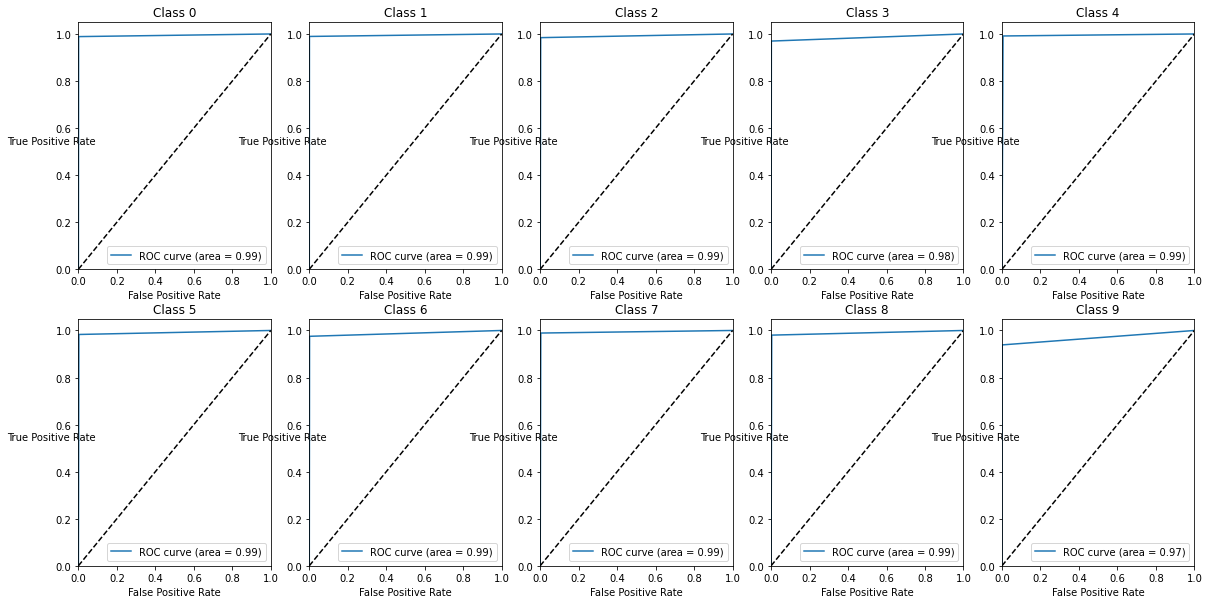

MNIST Training...:  53%|█████▎    | 8/15 [02:04<01:49, 15.64s/it]

roc_auc_score:  0.988342325109423
[8] Test Loss: 0.0727, Accuracy: 97.88%
Train Epoch: 9 
Confusion Matrix:  [[ 976    1    2    0    1    3    4    3    7    0]
 [   0 1124    0    0    0    0    2    4    1    1]
 [   0    2 1016    5    2    0    1   18    4    1]
 [   0    1    4  993    0   15    0    0    7    6]
 [   0    2    1    0  963    1    1    1    1   14]
 [   0    0    0    5    0  865    6    0    5    3]
 [   2    2    0    0    6    5  941    0    2    0]
 [   0    0    3    1    0    0    0  986    3    0]
 [   1    3    6    2    1    3    3    3  941    3]
 [   1    0    0    4    9    0    0   13    3  981]]
recall all: [0.97893681 0.99293286 0.96854147 0.96783626 0.97865854 0.97850679
 0.9822547  0.99295065 0.97412008 0.97032641]
recall avg: 0.9786
precision all: [0.99591837 0.99030837 0.98449612 0.98316832 0.98065173 0.96973094
 0.9822547  0.95914397 0.9661191  0.97224975]
precision avg: 0.9787275778063169
f1 avg: 0.9786106905159649


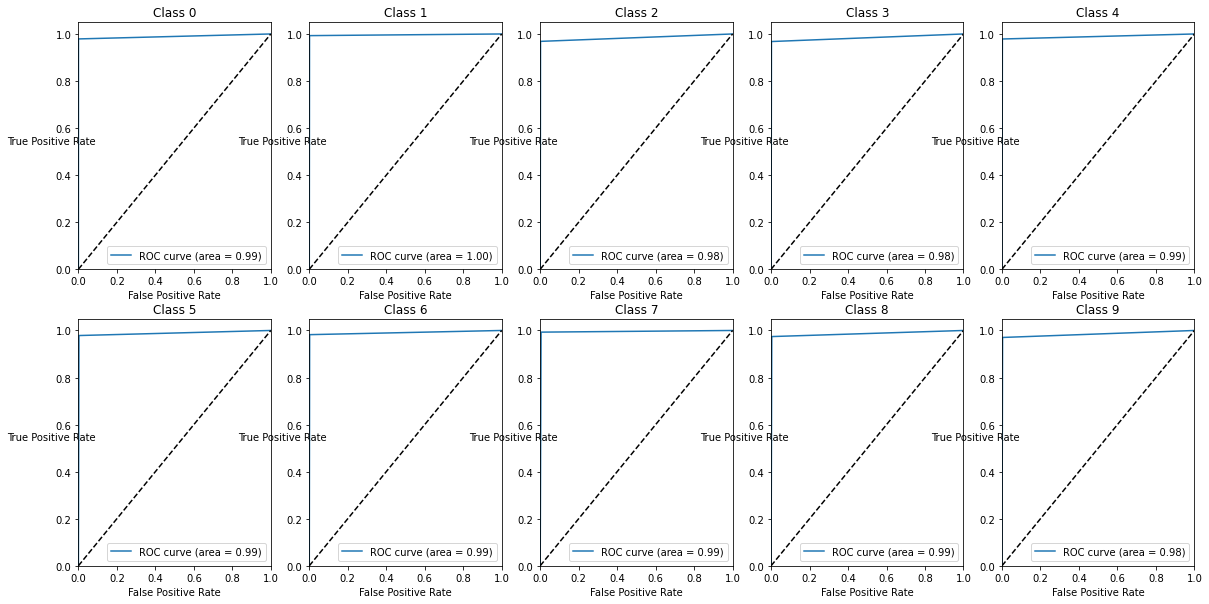

MNIST Training...:  60%|██████    | 9/15 [02:20<01:33, 15.56s/it]

roc_auc_score:  0.9880658926701351
[9] Test Loss: 0.0801, Accuracy: 97.86%
Train Epoch: 10 
Confusion Matrix:  [[ 969    1    2    0    1    1    1    3    1    1]
 [   1 1127    3    0    0    0    2    2    0    3]
 [   1    2 1009    3    1    0    1    6    3    0]
 [   1    0    2  996    0   14    0    4    7    5]
 [   0    0    1    0  950    2    2    0    3    5]
 [   0    0    0    2    0  858    1    0    1    3]
 [   5    3    2    0   11   10  950    0    4    0]
 [   0    0    4    2    1    1    0 1002    2    1]
 [   1    2    9    1    0    5    0    3  947    0]
 [   2    0    0    6   18    1    1    8    6  991]]
recall all: [0.98877551 0.99033392 0.9834308  0.96793003 0.98650052 0.99190751
 0.96446701 0.98914116 0.97830579 0.95934172]
recall avg: 0.9799
precision all: [0.98877551 0.99295154 0.97771318 0.98613861 0.96741344 0.96188341
 0.99164927 0.97470817 0.97227926 0.98216056]
precision avg: 0.9800389587262806
f1 avg: 0.9798920363439212


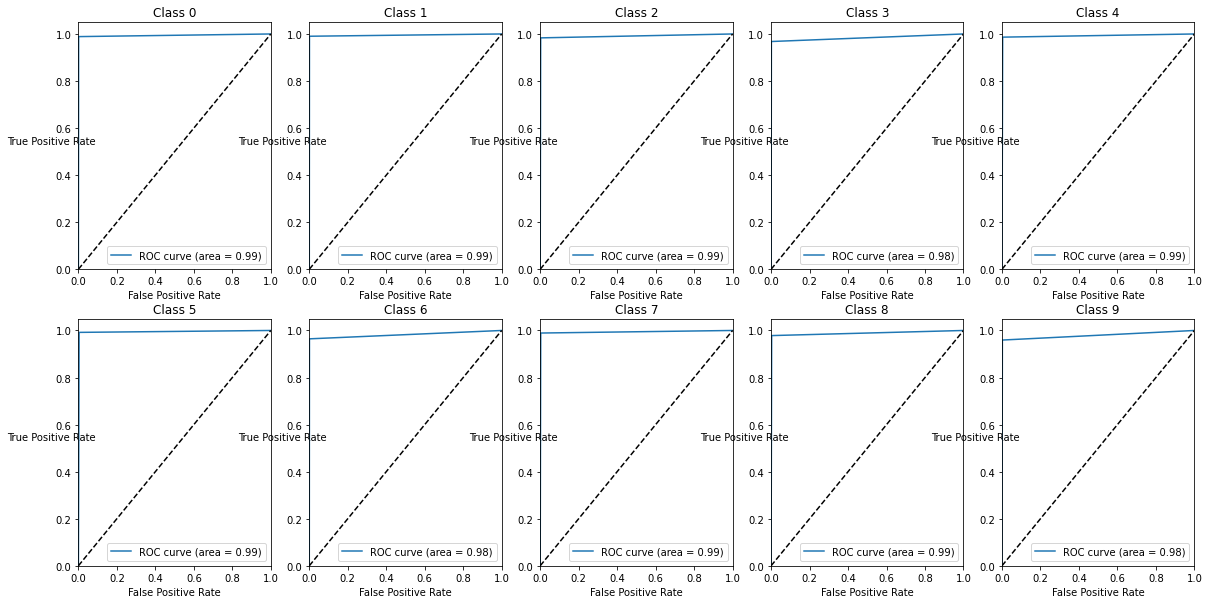

MNIST Training...:  67%|██████▋   | 10/15 [02:35<01:18, 15.67s/it]

roc_auc_score:  0.9888924013558867
[10] Test Loss: 0.0812, Accuracy: 97.99%
Train Epoch: 11 
Confusion Matrix:  [[ 972    0    2    1    1    3    4    2    3    3]
 [   0 1131    8    0    1    0    3    8    3    2]
 [   1    0 1011    4    3    0    1    7    0    0]
 [   1    0    1  992    0   14    0    3    8    5]
 [   0    0    0    0  951    1    2    1    0    5]
 [   0    0    0    5    0  858    8    0    0    5]
 [   2    1    0    0    5    3  937    0    1    1]
 [   0    0    3    2    1    2    0  996    3    2]
 [   3    3    7    4    2    9    3    4  955   13]
 [   1    0    0    2   18    2    0    7    1  973]]
recall all: [0.98082745 0.9783737  0.98442064 0.96875    0.990625   0.97945205
 0.98631579 0.98711596 0.95214357 0.96912351]
recall avg: 0.9776
precision all: [0.99183673 0.99647577 0.97965116 0.98217822 0.96843177 0.96188341
 0.97807933 0.9688716  0.98049281 0.96432111]
precision avg: 0.9777372292060038
f1 avg: 0.977599941510238


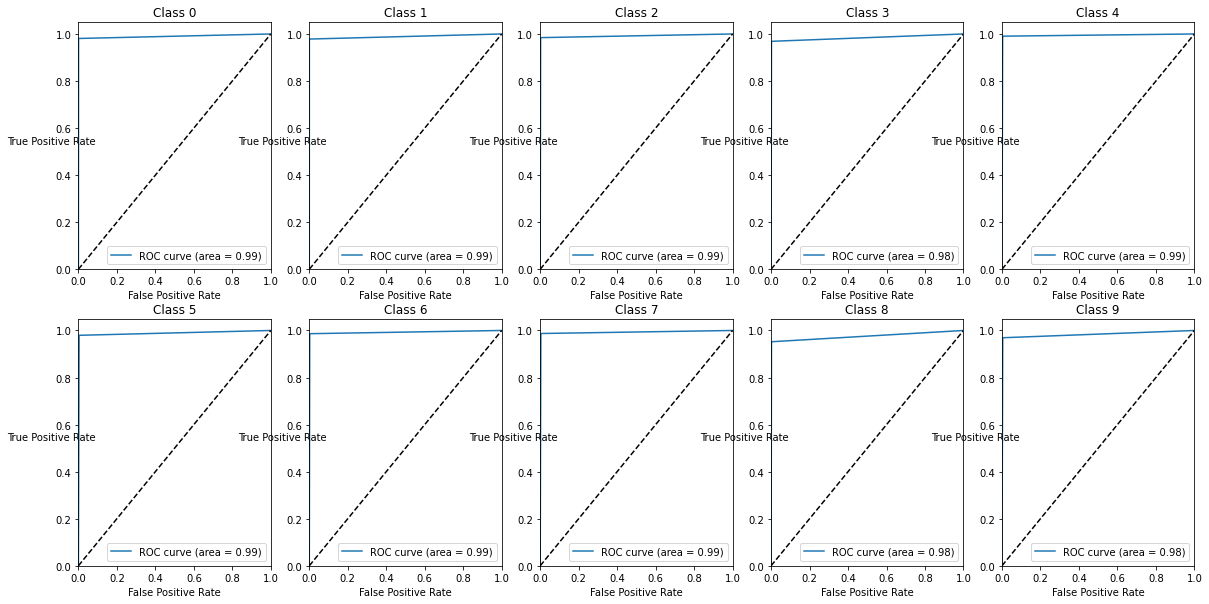

MNIST Training...:  73%|███████▎  | 11/15 [02:51<01:03, 15.76s/it]

roc_auc_score:  0.987615644575988
[11] Test Loss: 0.0956, Accuracy: 97.76%
Train Epoch: 12 
Confusion Matrix:  [[ 972    0    6    1    1    2    4    1    5    0]
 [   0 1132    6    0    0    0    2    7    3    3]
 [   0    1  992    2    1    0    0    5    0    0]
 [   1    0    3  983    0    9    0    1    4    1]
 [   0    0    5    0  956    1    7    2    3    8]
 [   0    0    0    9    1  871    3    0    3    4]
 [   2    2    3    0    5    4  939    0    4    0]
 [   0    0    8    5    1    0    0  994    3    1]
 [   1    0    9    3    0    4    2    2  944    1]
 [   4    0    0    7   17    1    1   16    5  991]]
recall all: [0.97983871 0.98178664 0.99100899 0.98103792 0.97352342 0.97755331
 0.97914494 0.98221344 0.97722567 0.95105566]
recall avg: 0.9774
precision all: [0.99183673 0.99735683 0.96124031 0.97326733 0.97352342 0.9764574
 0.98016701 0.96692607 0.96919918 0.98216056]
precision avg: 0.9775460472878443
f1 avg: 0.9774042807153904


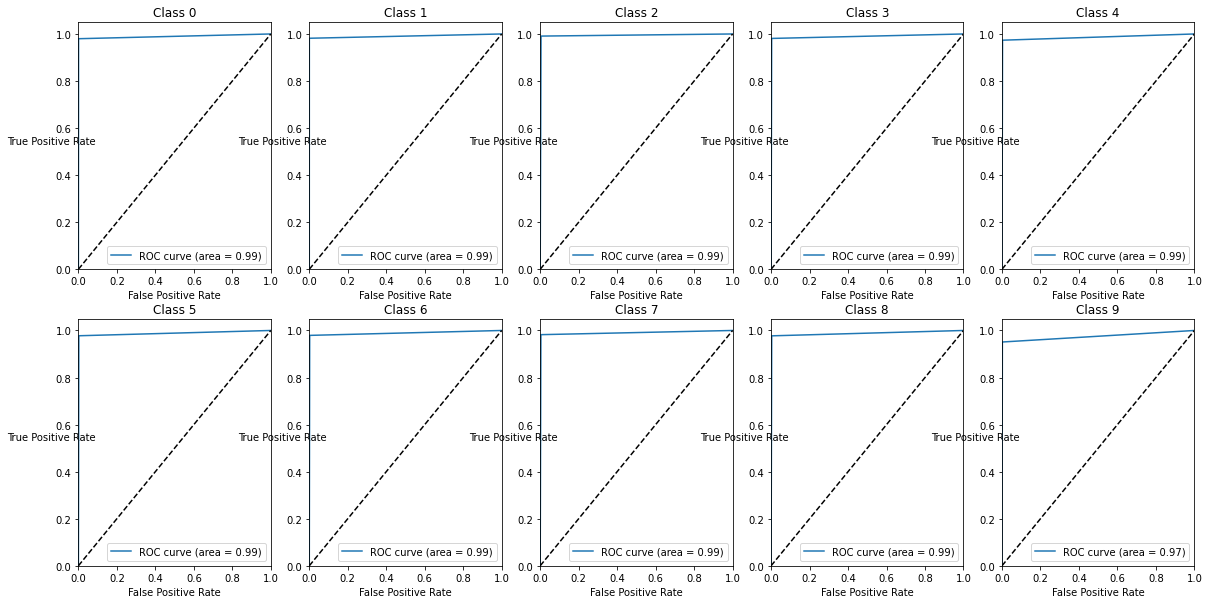

MNIST Training...:  80%|████████  | 12/15 [03:07<00:47, 15.71s/it]

roc_auc_score:  0.9874656427806702
[12] Test Loss: 0.1037, Accuracy: 97.74%
Train Epoch: 13 
Confusion Matrix:  [[ 968    0    0    0    0    2    1    1    3    0]
 [   0 1123    2    0    0    1    2    4    0    3]
 [   2    2 1009    6    3    0    0    7    4    1]
 [   0    0    3  988    0    9    0    0    4    2]
 [   0    0    2    2  961    3    3    0    3    8]
 [   0    0    0    2    0  863    4    0    1    1]
 [   5    1    1    0    4    7  944    0    3    0]
 [   0    1    6    5    2    1    0 1008    3    4]
 [   3    8    9    3    1    3    4    4  946    4]
 [   2    0    0    4   11    3    0    4    7  986]]
recall all: [0.99282051 0.98942731 0.97582205 0.98210736 0.97861507 0.99081515
 0.97823834 0.97864078 0.96040609 0.96951819]
recall avg: 0.9796
precision all: [0.9877551  0.98942731 0.97771318 0.97821782 0.97861507 0.96748879
 0.98538622 0.98054475 0.97125257 0.97720515]
precision avg: 0.9796146727491516
f1 avg: 0.9795882278025634


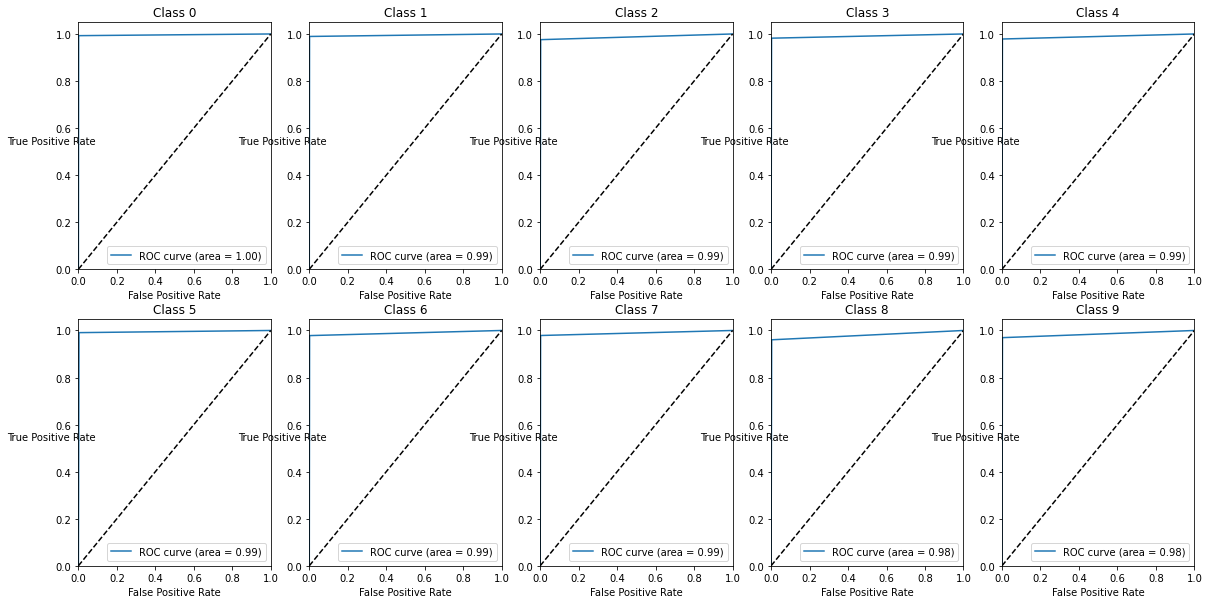

MNIST Training...:  87%|████████▋ | 13/15 [03:23<00:31, 15.75s/it]

roc_auc_score:  0.9886882691658837
[13] Test Loss: 0.1005, Accuracy: 97.96%
Train Epoch: 14 
Confusion Matrix:  [[ 972    0    1    0    0    3    4    0    3    1]
 [   1 1128    1    0    0    1    3    3    0    3]
 [   1    2 1019    5    4    0    1   11    5    2]
 [   1    0    2  974    0    4    1    4    9    2]
 [   1    0    1    0  957    1    2    0    3    5]
 [   0    0    0    8    0  879   21    0    2    3]
 [   2    1    0    0    6    0  920    0    0    1]
 [   0    0    4    5    2    1    0 1005    4    6]
 [   1    4    4    2    0    1    6    1  944    1]
 [   1    0    0   16   13    2    0    4    4  985]]
recall all: [0.98780488 0.98947368 0.97047619 0.97693079 0.98659794 0.96276013
 0.98924731 0.97857838 0.97925311 0.96097561]
recall avg: 0.9783
precision all: [0.99183673 0.9938326  0.9874031  0.96435644 0.97454175 0.98542601
 0.96033403 0.97762646 0.96919918 0.97621407]
precision avg: 0.9784233031364445
f1 avg: 0.9783047189172664


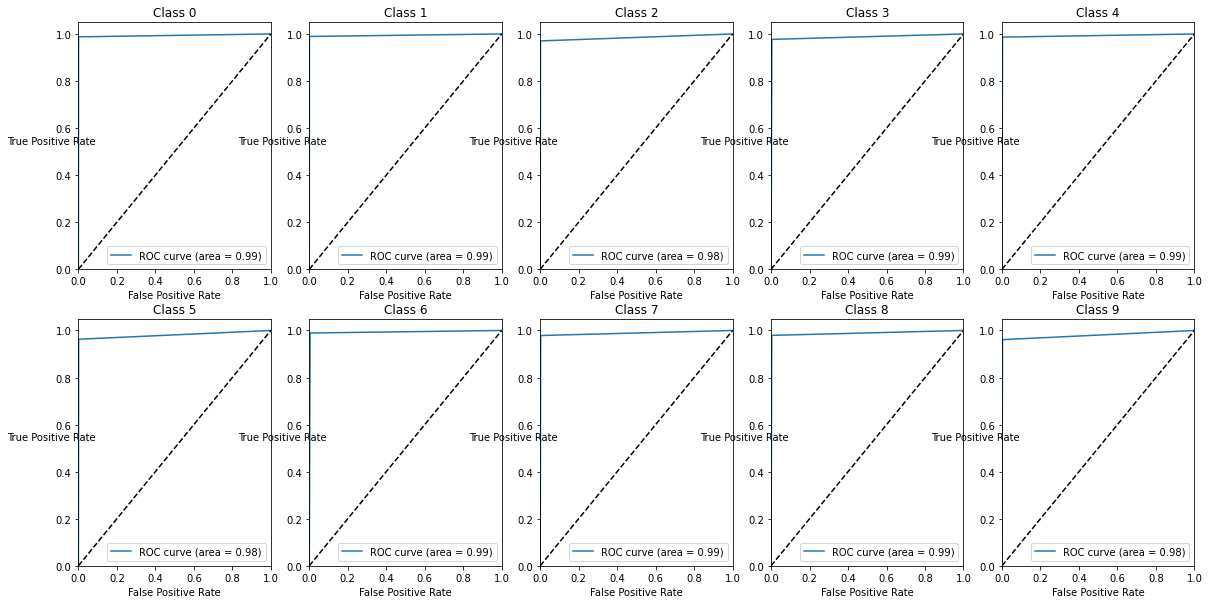

MNIST Training...:  93%|█████████▎| 14/15 [03:39<00:15, 15.74s/it]

roc_auc_score:  0.9879011638989594
[14] Test Loss: 0.1053, Accuracy: 97.83%
Train Epoch: 15 
Confusion Matrix:  [[ 972    0    1    1    0    2    3    2    5    0]
 [   0 1124    0    0    0    0    2    0    0    4]
 [   1    2 1017    5    1    0    0    7    2    1]
 [   1    0    1  978    0    3    0    1    3    3]
 [   0    0    1    0  960    1    6    0    5    5]
 [   1    1    0   16    0  878    4    0    4    2]
 [   2    2    1    0    6    3  940    0    2    0]
 [   0    1    9    5    1    1    0 1012    7    4]
 [   1    5    2    3    1    4    3    2  943    4]
 [   2    0    0    2   13    0    0    4    3  986]]
recall all: [0.98580122 0.99469027 0.98166023 0.98787879 0.98159509 0.96909492
 0.9832636  0.97307692 0.97417355 0.97623762]
recall avg: 0.981
precision all: [0.99183673 0.99030837 0.98546512 0.96831683 0.97759674 0.98430493
 0.98121086 0.9844358  0.96817248 0.97720515]
precision avg: 0.9810463862588418
f1 avg: 0.9810014585992504


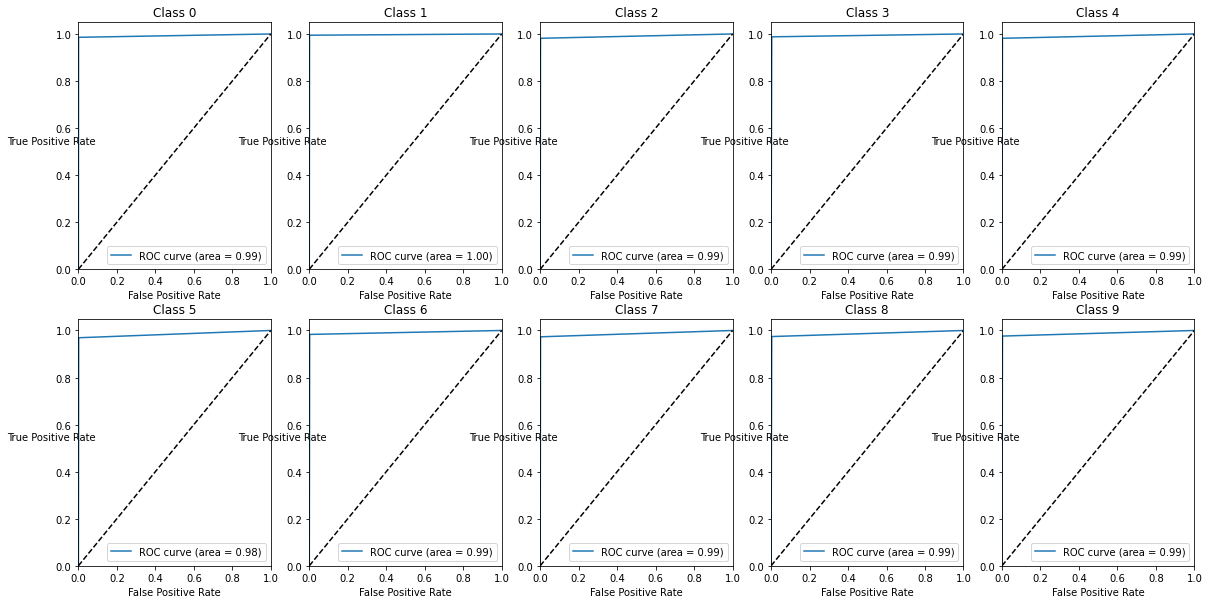

MNIST Training...: 100%|██████████| 15/15 [03:54<00:00, 15.64s/it]

roc_auc_score:  0.9893187509584569
[15] Test Loss: 0.0911, Accuracy: 98.10%


In [13]:
# tqdm 사용시 for문의 진행정도 표현가능 desc: describe로 왼쪽에 뜰 텍스트 정함.
for epoch in tqdm(range(1, 15 + 1), desc="MNIST Training...", mininterval=0.01):
    train(model, train_dataset, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataset)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    time.sleep(0.1)

In [14]:
writer.close()

In [16]:
# 텐서보드 띄우기
%load_ext tensorboard
%tensorboard --logdir runs --port=6016

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
